# CatBoost with Optuna Hyperparameter Tuning

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

In [2]:
# DATA_PATH = '../data/training/final/travel_ml.csv'
DATA_PATH = '../data/training/final/travel_insight_pruned.csv'
# VAL_DATA_PATH = '../data/validation/final/travel_ml.csv'
travel = pd.read_csv(DATA_PATH)
# travel_val = pd.read_csv(VAL_DATA_PATH)
travel.head()

,TRAVEL_ID,TRAVEL_LENGTH,total_payment,visit_move_cnt,IS_FAILED_TRIP,total_payment_per_day,visit_move_cnt_per_day
0,a_a014262,2,0.014607,5,1,0.246732,2.50
1,a_a006728,2,-0.310801,5,0,-0.269297,2.50
2,a_a015745,4,-0.345055,19,0,-0.452622,4.75
3,a_a010544,2,-0.250857,9,0,-0.174239,4.50
4,a_a012058,2,-0.062463,5,0,0.124515,2.50


In [3]:
# 학습에 사용할 피처값 선언
BINARY_CLASSIFICATION_TARGET = 'IS_FAILED_TRIP'

BINARY_CLASSIFICATION_FEATURES = [
    'TRAVEL_LENGTH',
    'visit_move_cnt',
    'total_payment',
    'total_payment_per_day',
    'visit_move_cnt_per_day'
]

In [4]:
# 데이터 선언
X = travel[BINARY_CLASSIFICATION_FEATURES]
y = travel[BINARY_CLASSIFICATION_TARGET]

In [5]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.3
)

In [6]:
# Hyperparameter 최적화를 위해 Optuna 라이브러리를 설치합니다.
try:
    import optuna
except ImportError:
    print("Optuna is not installed. Installing now...")
    !pip install optuna
    import optuna

# Optuna를 사용한 Hyperparameter 최적화
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
import numpy as np

# 1. Objective 함수 정의
def objective(trial):
    # CatBoost는 범주형 피처를 직접 처리할 수 있지만, XGBoost 노트북과의 일관성을 위해
    # 전처리된 숫자형 데이터를 그대로 사용합니다.

    # CatBoost 하이퍼파라미터 탐색 공간 정의
    param = {
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'verbose': 0,
        'random_seed': 42,
        'auto_class_weights': 'Balanced',  # 클래스 불균형 처리
        'iterations': trial.suggest_int('iterations', 300, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
    }

    model = CatBoostClassifier(**param)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_train_fold, y_train_fold,
                  eval_set=(X_val_fold, y_val_fold),
                  early_stopping_rounds=50,
                  verbose=0)
        
        preds = model.predict_proba(X_val_fold)[:, 1]
        pr_auc = average_precision_score(y_val_fold, preds)
        scores.append(pr_auc)

    return np.mean(scores)

# 2. Study 생성 및 최적화 실행
print("Starting hyperparameter optimization with Optuna for CatBoost...")
study = optuna.create_study(direction='maximize', study_name='catboost_optimization')
study.optimize(objective, n_trials=40)

# 3. 최적화 결과 확인
print("Optimization finished.")
print('Best trial:')
best_trial = study.best_trial

print(f'  Value (PR-AUC): {best_trial.value:.4f}')
print('  Best Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

# 4. 최적의 하이퍼파라미터로 모델 재학습
print("Training the best model on the full training data...")
best_params = best_trial.params
best_params['objective'] = 'Logloss'
best_params['eval_metric'] = 'AUC'
best_params['verbose'] = 0
best_params['random_seed'] = 42
best_params['auto_class_weights'] = 'Balanced'

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)
print("Best model trained successfully.")

/home/maroco/miniconda3/envs/mini_project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-09-27 13:25:47,535] A new study created in memory with name: catboost_optimization


Starting hyperparameter optimization with Optuna for CatBoost...


[I 2025-09-27 13:25:48,978] Trial 0 finished with value: 0.09623189628157174 and parameters: {'iterations': 353, 'learning_rate': 0.10202056592835619, 'depth': 3, 'l2_leaf_reg': 0.2832046983841582, 'border_count': 240}. Best is trial 0 with value: 0.09623189628157174.
[I 2025-09-27 13:25:51,707] Trial 1 finished with value: 0.10000032327696251 and parameters: {'iterations': 1155, 'learning_rate': 0.11427081993841838, 'depth': 8, 'l2_leaf_reg': 0.002150900063123601, 'border_count': 156}. Best is trial 1 with value: 0.10000032327696251.
[I 2025-09-27 13:25:52,947] Trial 2 finished with value: 0.09177027984240359 and parameters: {'iterations': 1844, 'learning_rate': 0.20644044282959526, 'depth': 6, 'l2_leaf_reg': 0.25371497541986887, 'border_count': 178}. Best is trial 1 with value: 0.10000032327696251.
[I 2025-09-27 13:25:55,472] Trial 3 finished with value: 0.10006111762830697 and parameters: {'iterations': 426, 'learning_rate': 0.039943153768275036, 'depth': 10, 'l2_leaf_reg': 0.005613

Optimization finished.
Best trial:
  Value (PR-AUC): 0.1092
  Best Params: 
    iterations: 1260
    learning_rate: 0.014496770087677555
    depth: 7
    l2_leaf_reg: 1.5277048861987954
    border_count: 32
Training the best model on the full training data...
Best model trained successfully.


In [7]:
# 베스트 모델 평가 (Train/Test)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, average_precision_score

threshold = 0.5
y_proba_train_gs = best_model.predict_proba(X_train)[:,1]
y_proba_test_gs = best_model.predict_proba(X_test)[:,1]
y_pred_train_gs = (y_proba_train_gs >= threshold).astype(int)
y_pred_test_gs = (y_proba_test_gs >= threshold).astype(int)
print(f'Decision threshold: {threshold:.2f}')
print('='*5+'Train (BestModel)'+'='*70)
print(f'Acc : {accuracy_score(y_train, y_pred_train_gs):.4f}')
print('Confusion Matrix')
print(confusion_matrix(y_train, y_pred_train_gs))
print(classification_report(y_train, y_pred_train_gs))
print(f'ROC-AUC : {roc_auc_score(y_train, y_proba_train_gs):.4f}')
print(f'PR-AUC  : {average_precision_score(y_train, y_proba_train_gs):.4f}')
print('='*5+'Test (BestModel)'+'='*70)
print(f'Acc : {accuracy_score(y_test, y_pred_test_gs):.4f}')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test_gs))
print(classification_report(y_test, y_pred_test_gs))
print(f'ROC-AUC : {roc_auc_score(y_test, y_proba_test_gs):.4f}')
print(f'PR-AUC  : {average_precision_score(y_test, y_proba_test_gs):.4f}')

Decision threshold: 0.50
=====Train (BestModel)======================================================================
Acc : 0.7951
Confusion Matrix
[[3106  753]
 [  73   99]]
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      3859
           1       0.12      0.58      0.19       172

    accuracy                           0.80      4031
   macro avg       0.55      0.69      0.54      4031
weighted avg       0.94      0.80      0.85      4031

ROC-AUC : 0.7669
PR-AUC  : 0.1258
=====Test (BestModel)======================================================================
Acc : 0.7679
Confusion Matrix
[[1286  363]
 [  38   41]]
              precision    recall  f1-score   support

           0       0.97      0.78      0.87      1649
           1       0.10      0.52      0.17        79

    accuracy                           0.77      1728
   macro avg       0.54      0.65      0.52      1728
weighted avg       0.93      0.77      0.83

In [8]:
# True positive rows (predict=1 & true=1)
import pandas as pd

y_pred_test_series = pd.Series(y_pred_test_gs, index=X_test.index, name='predicted')
y_proba_test_series = pd.Series(y_proba_test_gs, index=X_test.index, name='predicted_proba')
tp_mask = (y_test == 1) & (y_pred_test_series == 1)
tp_df = X_test.loc[tp_mask].copy()
tp_df['actual'] = y_test.loc[tp_mask]
tp_df['predicted'] = y_pred_test_series.loc[tp_mask]
tp_df['predicted_proba'] = y_proba_test_series.loc[tp_mask]
print(f'Total true positives in test set: {tp_df.shape[0]}')
tp_df.to_csv('TP_traveler_catboost.csv')

Total true positives in test set: 41


In [9]:
# True negative rows (predict=0 & true=0)
import pandas as pd

y_pred_test_series = pd.Series(y_pred_test_gs, index=X_test.index, name='predicted')
y_proba_test_series = pd.Series(y_proba_test_gs, index=X_test.index, name='predicted_proba')
tn_mask = (y_test == 0) & (y_pred_test_series == 0)
tn_df = X_test.loc[tn_mask].copy()
tn_df['actual'] = y_test.loc[tn_mask]
tn_df['predicted'] = y_pred_test_series.loc[tn_mask]
tn_df['predicted_proba'] = y_proba_test_series.loc[tn_mask]
print(f'Total true negatives in test set: {tn_df.shape[0]}')
tn_df.to_csv('TN_traveler_catboost.csv')

Total true negatives in test set: 1286


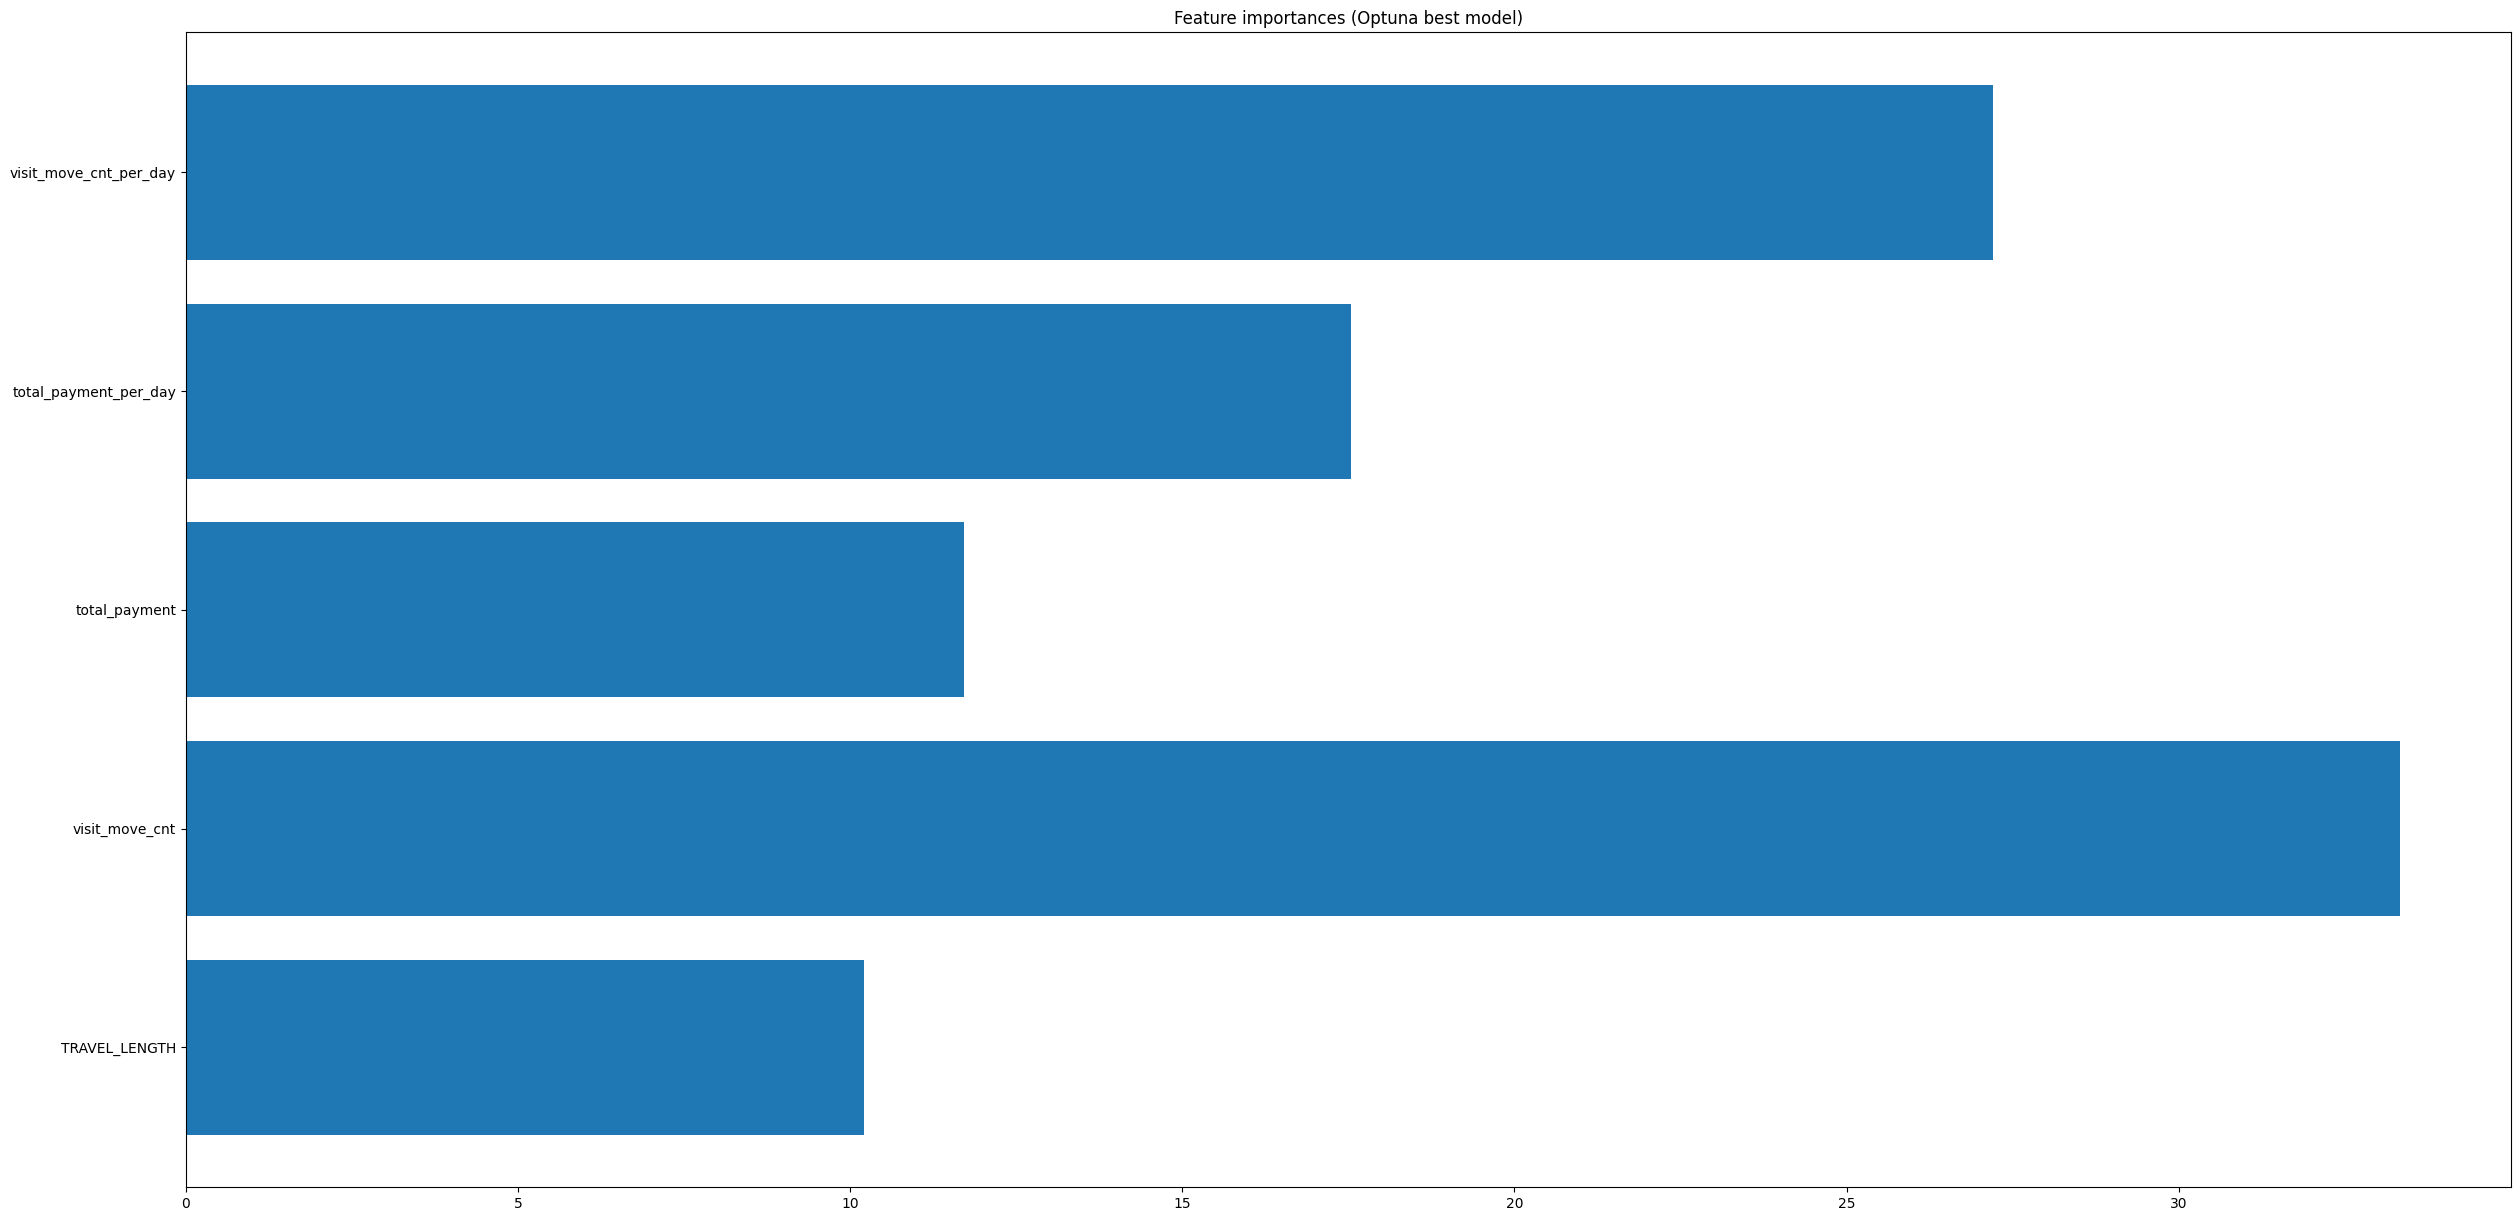

visit_move_cnt            33.331779
visit_move_cnt_per_day    27.202391
total_payment_per_day     17.541548
total_payment             11.709622
TRAVEL_LENGTH             10.214659
dtype: float64


In [10]:
# 특성 중요도 (베스트 모델)
import matplotlib.pyplot as plt

plt.figure(figsize=(30,15))
plt.barh(X.columns, best_model.get_feature_importance())
plt.title('Feature importances (Optuna best model)')
plt.show()

feat_imp = best_model.get_feature_importance()
feat_names = X_train.columns
feat_imp_ser = pd.Series(feat_imp, index=feat_names)

sorted_feature_importances = feat_imp_ser.sort_values(ascending=False)
print(sorted_feature_importances)